# Lab 3 - Fitting: Stone et al.

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

### (0) Import necessary packages and load data

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.model_selection import LeaveOneOut

# np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if diffFunAnon(0) * diffFunAnon(Rtot) > 0:
        raise RuntimeError('There is no solution with these parameters. Are your inputs correct?')

    # Vector of binomial coefficients
    Req = sp.optimize.brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(sp.special.binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))

    # Calculate numXlinks from equation 4
    nXlink = np.sum(np.multiply(vieq[1:], np.arange(1, v, dtype=np.float)))

    return (Lbound, Rbnd, Rmulti, nXlink)

# Load data
data = np.loadtxt('wk3-stone.csv', delimiter=',')

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
Xs, Ys, Vs = np.hsplit(data, 3)
Xs, Ys, Vs = np.squeeze(Xs), np.squeeze(Ys), np.squeeze(Vs)

### (1) We will fit the data contained within Fig. 3B. Plot this data.

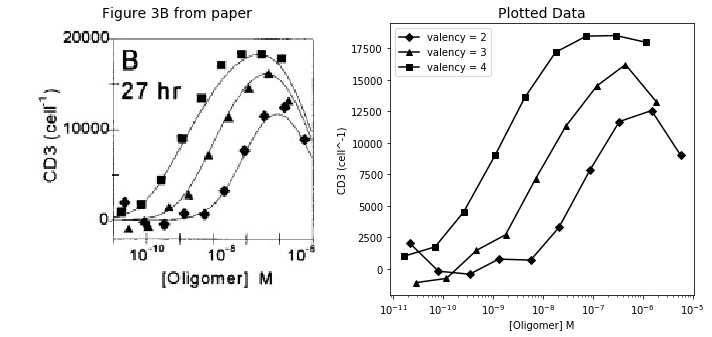

In [2]:
plt.figure(figsize=(12,5))
# Show Figure 3B from paper
plt.subplot(121)
plt.imshow(mpimg.imread('Figure3B.png'))
plt.axis('off')
plt.title('Figure 3B from paper', size=14)

# Plot Xs vs. Ys for each of the valencies
plt.subplot(122)
plt.semilogx(Xs[Vs==2,], Ys[Vs==2], marker='D', c='k')
plt.semilogx(Xs[Vs==3,], Ys[Vs==3], marker='^', c='k')
plt.semilogx(Xs[Vs==4,], Ys[Vs==4], marker='s', c='k')
plt.title('Plotted Data', size=14)
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['valency = 2', 'valency = 3', 'valency = 4']);

### (2) First, to fit our model to data, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

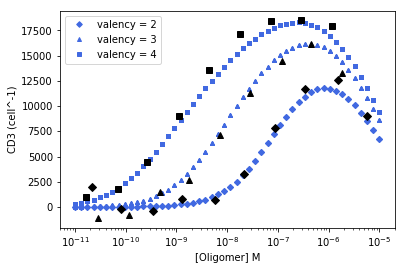

In [3]:
# Initialize constants
Rtot = 24000
K_D = 1.7*10**-6
K_X = 3.15*10**-4
scale = 1

# Xs and for plotting
XsSim = np.repeat(np.logspace(-11, -5), 3)

# Multiplies cell response by scale factor
def make_prediction(Rtot, Kd, v, Kx, L0, scale_factor):
    make_prediction_array = np.zeros(len(L0))
    for n in range(0, len(L0)):
        [_,_,answer,_] = StoneMod(Rtot, Kd, v, Kx, L0[n])
        make_prediction_array[n] = scale_factor*answer
    return make_prediction_array
    
# Calculate cell response for each of the valencies using model (StoneMod)
# Rmulti is 2-D array, with one row for each valency
Rmulti = np.zeros((3, len(XsSim)))
# Rmulti = list([np.zeros(len(XsSim)), np.zeros(len(Xs[Vs==3])), np.zeros(len(Xs[Vs==4]))])
for i in range(0, 3):
    val = i + 2
    for n in range(0, len(XsSim)):
        Rmulti[i] = make_prediction(Rtot, K_D, val, K_X, XsSim, scale)

# Plot the StoneMod models and the data for each valencies
plt.semilogx(XsSim, Rmulti[0,], 'D', c='royalblue', markersize=4)
plt.semilogx(XsSim, Rmulti[1,], '^', c='royalblue', markersize=4)
plt.semilogx(XsSim, Rmulti[2,], 's', c='royalblue', markersize=4)
plt.semilogx(Xs[Vs==2,], Ys[Vs==2], 'D', c='k')
plt.semilogx(Xs[Vs==3,], Ys[Vs==3], '^', c='k')
plt.semilogx(Xs[Vs==4,], Ys[Vs==4], 's', c='k')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['valency = 2', 'valency = 3', 'valency = 4']);

### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

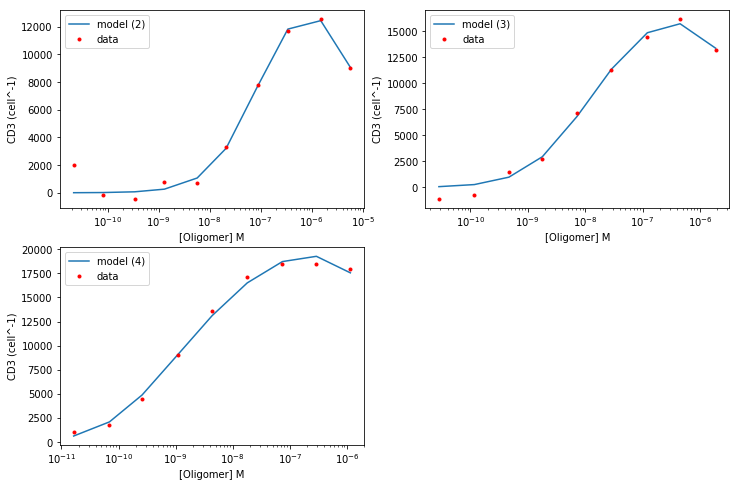

In [4]:
# Residual function
def residuals(x0, data, Rtot, v, L0):
    # x0 = [Kd, Kx, scale_factor]
    return (data-make_prediction(Rtot, x0[0], v, x0[1], L0, x0[2]))

# Find the least squares solution for each valency
ls_sq2 = sp.optimize.least_squares(residuals, np.array([K_D, K_X, scale]), args=(Ys[Vs==2], Rtot, 2, Xs[Vs==2]), bounds = (0,1000))
ls_sq3 = sp.optimize.least_squares(residuals, np.array([K_D, K_X, scale]), args=(Ys[Vs==3], Rtot, 3, Xs[Vs==3]), bounds = (0,1000))
ls_sq4 = sp.optimize.least_squares(residuals, np.array([K_D, K_X, scale]), args=(Ys[Vs==4], Rtot, 4, Xs[Vs==4]), bounds = (0,1000))

# Plot all the least square results
plt.figure(figsize=(12,8))
# Plot valency = 2
plt.subplot(221)
plt.semilogx(Xs[Vs==2], make_prediction(Rtot, ls_sq2.x[0], 2, ls_sq2.x[1], Xs[Vs==2], ls_sq2.x[2]))
plt.semilogx(Xs[Vs==2], Ys[Vs==2], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['model (2)', 'data'])
# Plot valency = 3
plt.subplot(222)
plt.semilogx(Xs[Vs==3], make_prediction(Rtot, ls_sq3.x[0], 3, ls_sq3.x[1], Xs[Vs==3], ls_sq3.x[2]))
plt.semilogx(Xs[Vs==3], Ys[Vs==3], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['model (3)', 'data'])
# Plot valency = 4
plt.subplot(223)
plt.semilogx(Xs[Vs==4], make_prediction(Rtot, ls_sq4.x[0], 4, ls_sq4.x[1], Xs[Vs==4], ls_sq4.x[2]))
plt.semilogx(Xs[Vs==4], Ys[Vs==4], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['model (4)', 'data']);

### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

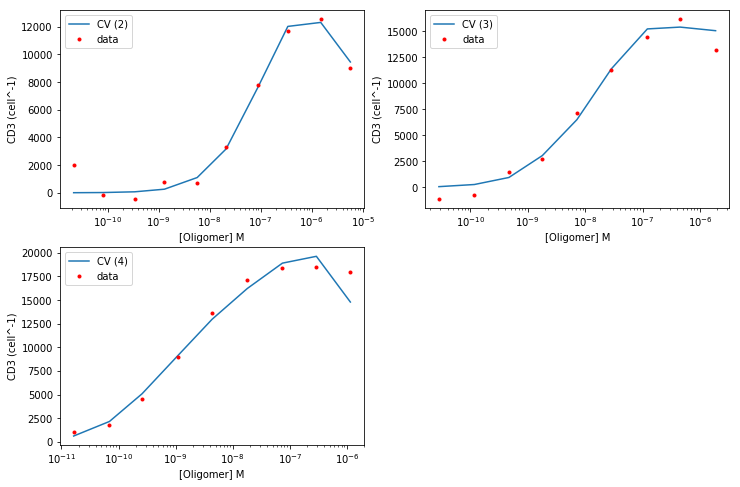

In [5]:
# Split into train/test data for LOOCV
loo = LeaveOneOut()

# This list will store all of the model predictions made by cross validation
cv_model = list([np.zeros(len(Xs[Vs==2])), np.zeros(len(Xs[Vs==3])), np.zeros(len(Xs[Vs==4]))])

# for each valency
for i in range(0, 3):
    val = i + 2
    # split into training and testing data
    for train, test in loo.split(Xs[Vs==val]):
        X_train = Xs[Vs==val][train]
        Y_train = Ys[Vs==val][train]
        
        # use least squares on training data
        ls_sq = sp.optimize.least_squares(residuals, np.array([K_D, K_X, scale]), args=(Y_train, Rtot, val, X_train), bounds = (0,1000))
        
        # predict value for test data
        cv_model[i][test] = make_prediction(Rtot, ls_sq.x[0], val, ls_sq.x[1], Xs[Vs==val][test], ls_sq.x[2])

# Plot all the least square results
plt.figure(figsize=(12,8))
# Plot valency = 2
plt.subplot(221)
plt.semilogx(Xs[Vs==2], cv_model[0])
plt.semilogx(Xs[Vs==2], Ys[Vs==2], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['CV (2)', 'data'])
# Plot valency = 3
plt.subplot(222)
plt.semilogx(Xs[Vs==3], cv_model[1])
plt.semilogx(Xs[Vs==3], Ys[Vs==3], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['CV (3)', 'data'])
# Plot valency = 4
plt.subplot(223)
plt.semilogx(Xs[Vs==4], cv_model[2])
plt.semilogx(Xs[Vs==4], Ys[Vs==4], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['CV (4)', 'data']);

### (5) Using bootstrap estimation, plot the measured vs. predicted data.
Standard deviation is designated as the confidence interval

In [6]:
def resample(X, n):
    '''Resamples n number of samples from X and returns resampled array'''
    resample_index = np.floor(np.random.rand(n)*len(X)).astype(int)
    return resample_index

# Number of distributions bootstrap will run per valency
num_dist = 100

# Stores Kd, Kx, scale, for each trial
bootstrap_model = list([ np.zeros((num_dist, 3)), np.zeros((num_dist, 3)), np.zeros((num_dist, 3)) ])

# For each valency
for i in range(0, 3):
    val = i + 2
    X = Xs[Vs==val]
    Y = Ys[Vs==val]
    
    for bootstrap_i in range(num_dist):
        # resample for new X and Y
        resamp_ind = resample(X, len(X))
        Xnew = X[resamp_ind]
        Ynew = Y[resamp_ind]
        
        # use least squares on resampled data and store Kd, Kx, scale
        ls_sq = sp.optimize.least_squares(residuals, np.array([K_D, K_X, scale]), args=(Ynew, Rtot, val, Xnew), bounds = (0,1000))
        bootstrap_model[i][bootstrap_i,] = ls_sq.x
        
# Apply StoneMod on each bootstrap
bootstrap_data_2 = np.zeros((num_dist, len(Xs[Vs==2])))
bootstrap_data_3 = np.zeros((num_dist, len(Xs[Vs==3])))
bootstrap_data_4 = np.zeros((num_dist, len(Xs[Vs==4])))
for i in range(num_dist):
    bootstrap_data_2[i] = make_prediction(Rtot, bootstrap_model[0][:,0][i], 2, bootstrap_model[0][:,1][i], Xs[Vs==2], bootstrap_model[0][:,2][i])
    bootstrap_data_3[i] = make_prediction(Rtot, bootstrap_model[0][:,0][i], 3, bootstrap_model[0][:,1][i], Xs[Vs==3], bootstrap_model[0][:,2][i])
    bootstrap_data_4[i] = make_prediction(Rtot, bootstrap_model[0][:,0][i], 4, bootstrap_model[0][:,1][i], Xs[Vs==4], bootstrap_model[0][:,2][i])

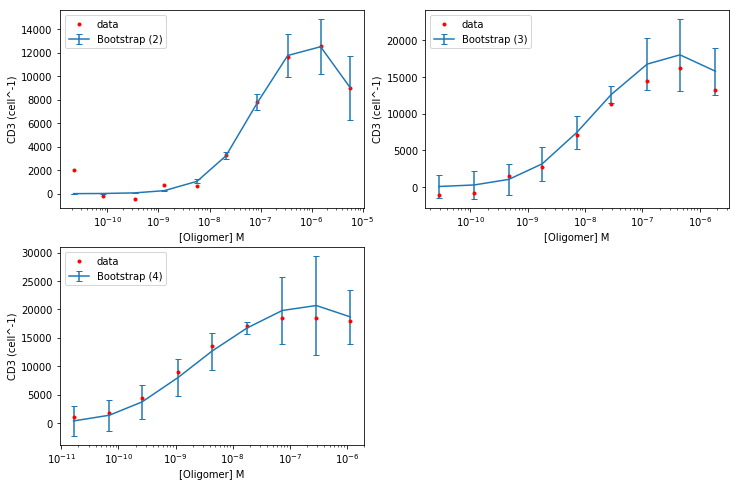

In [7]:
# Standard deviation designated as the confidence interval
plt.figure(figsize=(12, 8))
# Plot valency = 2
plt.subplot(221)
plt.errorbar(Xs[Vs==2], np.median(bootstrap_data_2, axis=0), np.std(bootstrap_data_2, axis=0), capsize=3)
plt.semilogx(Xs[Vs==2], Ys[Vs==2], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['data', 'Bootstrap (2)'])
# Plot valency = 3
plt.subplot(222)
plt.errorbar(Xs[Vs==3], np.median(bootstrap_data_3, axis=0), np.std(bootstrap_data_3, axis=0), capsize=3)
plt.semilogx(Xs[Vs==3], Ys[Vs==3], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['data', 'Bootstrap (3)'])
# Plot valency = 4
plt.subplot(223)
plt.errorbar(Xs[Vs==4], np.median(bootstrap_data_4, axis=0), np.std(bootstrap_data_4, axis=0), capsize=3)
plt.semilogx(Xs[Vs==4], Ys[Vs==4], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['data', 'Bootstrap (4)']);

### (6) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error.

Which parameter influences the fit the most? Which one the least?

In [8]:
# We will be analyzing StoneMod when valency = 4
val = 4
X = Xs[Vs==val]
Y = Ys[Vs==val]

# This function calculates SSE (sum of squared errors)
def calc_sse(data, model):
    sum = 0
    for n in range(0, len(data)):
        sum += (data[n]-model[n])**2
    return sum

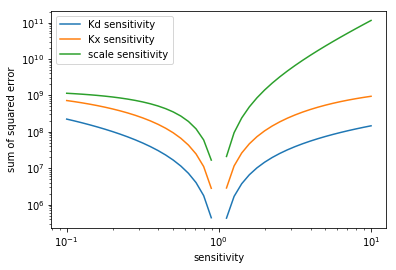

In [9]:
# Vary Kd, Kx, and scale by up to 10-fold up and down
fold10 = np.logspace(-1, 1, num = 41)
sensitivity_kd = np.zeros((len(fold10), 9))
sensitivity_kx = np.zeros((len(fold10), 9))
sensitivity_sc = np.zeros((len(fold10), 9))

# Make predictions based on varied Kd, Kx, scale
for i in range(len(fold10)):
    sensitivity_kd[i] = make_prediction(Rtot, fold10[i]*K_D, val, K_X, X, scale)
    sensitivity_kx[i] = make_prediction(Rtot, K_D, val, fold10[i]*K_X, X, scale)
    sensitivity_sc[i] = make_prediction(Rtot, K_D, val, K_X, X, fold10[i]*scale)
    
# Find SSE for varied Kd, Kx, scale
errors_kd = np.zeros(len(fold10))
errors_kx = np.zeros(len(fold10))
errors_sc = np.zeros(len(fold10))
for i in range(len(fold10)):
    errors_kd[i] = calc_sse(make_prediction(Rtot, K_D, val, K_X, X, scale), sensitivity_kd[i])
    errors_kx[i] = calc_sse(make_prediction(Rtot, K_D, val, K_X, X, scale), sensitivity_kx[i])
    errors_sc[i] = calc_sse(make_prediction(Rtot, K_D, val, K_X, X, scale), sensitivity_sc[i])

plt.loglog(fold10, errors_kd)
plt.loglog(fold10, errors_kx)
plt.loglog(fold10, errors_sc)
plt.legend(['Kd sensitivity', 'Kx sensitivity', 'scale sensitivity'])
plt.xlabel('sensitivity')
plt.ylabel('sum of squared error');

Varying scale will influence the cell response the most. The SSE increases by magnitude of 11 when scale is increased 10-fold. 
Varying Kd will influence the cell response the least. The SSE increases only by magnitude of 8 when Kd is either increased or decreased 10-fold.

### (7) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? What can you say about which quantities will be most exactly predicted?

Mean standard deviation of Rmulti: 3926.60171714


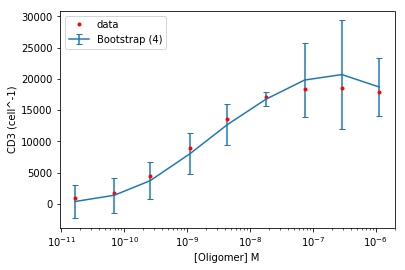

In [10]:
# Again, we will use valency = 4 for demonstration
val = 4

# Plot bootstrap and confidence intervals for Rmulti
Rmulti_x4, Rmulti_bootstrap4 = np.log(Xs[Vs==4]), make_prediction(Rtot, np.median(bootstrap_model[2][:,0]), 4, np.median(bootstrap_model[2][:,1]), Xs[Vs==4], np.median(bootstrap_model[2][:,2]))

# Plot Rmulti for valency = 4
plt.errorbar(Xs[Vs==4], np.median(bootstrap_data_4, axis=0), np.std(bootstrap_data_4, axis=0), capsize=3)
plt.semilogx(Xs[Vs==4], Ys[Vs==4], '.', c='r')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend(['data', 'Bootstrap (4)']);

# Print mean of std dev
print('Mean standard deviation of Rmulti:', np.mean(np.std(bootstrap_data_4, axis=0)))

Mean standard deviation of Lbound: 751.371750408


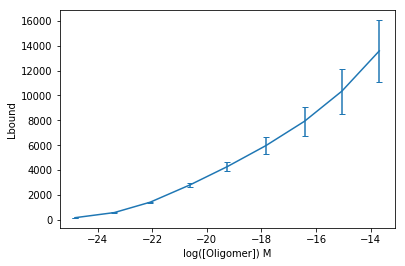

In [11]:
# Modify make_prediction to analyze Lbound
def make_prediction_Lbound(Rtot, Kd, v, Kx, L0, scale_factor):
    make_prediction_array = np.zeros(len(L0))
    for n in range(0, len(L0)):
        [answer,_,_,_] = StoneMod(Rtot, Kd, v, Kx, L0[n])
        make_prediction_array[n] = scale_factor*answer
    return make_prediction_array

# Predict Lbound
bootstrap_Lbound_4 = np.zeros((num_dist, len(Xs[Vs==4])))
Lbound_x_4 = np.log(Xs[Vs==4])
for i in range(num_dist):
    bootstrap_Lbound_4[i] = make_prediction_Lbound(Rtot, bootstrap_model[2][:,0][i], 4, bootstrap_model[2][:,1][i], Xs[Vs==4], bootstrap_model[2][:,2][i])

# Plot bootstrap and confidence intervals for Lbound
plt.errorbar(Lbound_x_4, np.median(bootstrap_Lbound_4, axis=0), np.std(bootstrap_Lbound_4, axis=0), capsize=3)
plt.xlabel('log([Oligomer]) M')
plt.ylabel('Lbound');

# Print mean of std dev
print('Mean standard deviation of Lbound:', np.mean(np.std(bootstrap_Lbound_4, axis=0)))

Mean standard deviation of Rbnd: 550.214092725


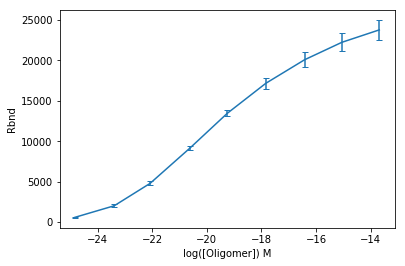

In [12]:
# Modify make_prediction to analyze Rbnd
def make_prediction_Rbnd(Rtot, Kd, v, Kx, L0, scale_factor):
    make_prediction_array = np.zeros(len(L0))
    for n in range(0, len(L0)):
        [_,answer,_,_] = StoneMod(Rtot, Kd, v, Kx, L0[n])
        make_prediction_array[n] = scale_factor*answer
    return make_prediction_array

# Predict Rbnd 
bootstrap_Rbnd_4 = np.zeros((num_dist, len(Xs[Vs==4])))
Rbnd_x_4 = np.log(Xs[Vs==4])
for i in range(num_dist):
    bootstrap_Rbnd_4[i] = make_prediction_Rbnd(Rtot, bootstrap_model[2][:,0][i], 4, bootstrap_model[2][:,1][i], Xs[Vs==4], bootstrap_model[2][:,2][i])

# Plot bootstrap and confidence intervals for Rbnd
plt.errorbar(Rbnd_x_4, np.median(bootstrap_Rbnd_4, axis=0), np.std(bootstrap_Rbnd_4, axis=0), capsize=3)
plt.xlabel('log([Oligomer]) M')
plt.ylabel('Rbnd');

# Print mean of std dev
print('Mean standard deviation of Rbnd:', np.mean(np.std(bootstrap_Rbnd_4, axis=0)))

Rmulti is the least specified quantity and Rbnd is the most specified quantity.

### (8) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. In general, which do you think is better for exactly fitting the model: more measurements of the same type or more measurements of different types?

Currently, my make_prediction function and my residuals function only take in Rmulti. In order to fit data around multimerized measurements, these functions must also include other measurement types to calculate the residual since the residuals can be interpreted as a loss function. Measurements of different types should be better for fitting the model since the residuals can take into account other measurements and minimize the error to give a better model.